<h2> Poniższe dwa bloki są pomocniczymi funkcjami do wczytywania i przerabiania bazy MNIST

In [3]:
### Helper function for uploading MNIST dataset ###

import os
import struct
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte/data')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte/data')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte/data')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte/data')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

In [4]:
### Helper function turning MNIST data to matrix ###
def toMatrix(data, maxItems=1000):
    datalist = [t for t in data]
    m = maxItems
    n = 28 * 28 + 1
    X = np.matrix(np.zeros(m * n)).reshape(m, n)
    Y = np.matrix(np.zeros(m)).reshape(m, 1)
    for i, (label, image) in enumerate(datalist[:m]):
        X[i, 0] = 1 # bias term
        X[i, 1:] = image.reshape(28*28,)
        Y[i] = label
    return X, Y

<h2> Zaczynamy! Najpierw wczytamy sobie bazę MNIST i zobaczymy jak wygląda

In [5]:
### Reading training and testing data ###

data_train = list(read("training"))
data_test = list(read("testing"))

train = toMatrix(data_train)
test = toMatrix(data_test)

In [6]:
### Checking volume of each of one training example ###
train[0].shape

(1000, 785)

In [7]:
### First element is a bias value, so we're taking all others, which are pixels of the MNIST image ###
### which is 28x28 = 784 ###

example = test[0][1][:,1:]
example.shape

(1, 784)

Label: 9.0


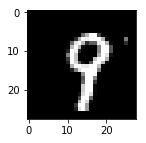

In [8]:
### Lookup example image ####

index = random.randint(0, len(train[0]))
image = np.resize(train[0][index], (28,28))

plt.figure(figsize=(2,2))
plt.imshow(image, cmap="gray")
print("Label: " + str(train[1][index,0]))

<h2> Teraz wczytujemy wytrenowane już wagi oraz bias

In [9]:
### Loading already trained weights and biases ###
thetas = []
biases = []
for i in range(6):
    thetas.append(np.matrix(np.load("6layers/Theta" + str(i+1) + ".npy")))
    biases.append(np.matrix(np.load("6layers/Beta" + str(i+1) + ".npy")))

<h2> Definiujemy funkcję softmax

In [10]:
def softmax(X):
    return np.exp(X)/np.sum(np.exp(X))

<h2> Aby w końcu sklasyfikować testowe przykłady

In [11]:
accuracy = 0.0
for i in range(len(test[1][:])):
    layer1 = np.tanh((test[0][i][:,1:]*thetas[0])+biases[0])
    layer2 = np.tanh((layer1*thetas[1])+biases[1])
    layer3 = np.tanh((layer2*thetas[2])+biases[2])
    layer4 = np.tanh((layer3*thetas[3])+biases[3])
    layer5 = np.tanh((layer4*thetas[4])+biases[4])
    probabilities = softmax((layer5*thetas[5])+biases[5])
    
    classifications = np.argmax(probabilities)
    correct = int(test[1][i])
    print(correct, "<=>", classifications, " - ", correct == classifications, np.round(probabilities, 4).tolist())
    accuracy += correct == classifications
print("Accuracy =", accuracy/float(len(test[0])))
    

7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
0 <=> 0  -  True [[0.9998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0001]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9997, 0.0, 0.0, 0.0, 0.0, 0.0003]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.9998]]
5 <=> 5  -  True [[0.0001, 0.0, 0.0003, 0.0003, 0.0003, 0.9835, 0.0094, 0.0, 0.0055, 0.0007]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.9998]]
0 <=> 0  -  True [[0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9998]]
0 <=> 0  -  Tru

3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9998]]
7 <=> 7  -  True [[0.0, 0.0, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.9998, 0.0, 0.0]]
4 <=> 9  -  False [[0.0, 0.0, 0.0001, 0.0, 0.0123, 0.0001, 0.0002, 0.0001, 0.0005, 0.9867]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9997, 0.0, 0.0, 0.0, 0.0, 0.0003]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0001]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.9998]]
2 <=> 2  -  True [[0.0, 0.0, 0.9996, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0]]
5 <=> 5  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0]]
4 <=> 4  -  True [[0.0001, 0.0, 0.0002, 0.0, 0.9985, 0.0, 0.001, 0.0, 0.0001, 0.0001]]
7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]]
7 <=> 7  -  True [[0.0, 0.0002, 0.0001, 0.0002, 0.0129, 0.0, 0.0

7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
8 <=> 8  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.9997, 0.0001]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0001]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0001, 0.0, 0.9997, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
8 <=> 8  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0001, 0.0, 0.0, 0.9997, 0.0001]]
8 <=> 8  -  True [[0.0, 0.0003, 0.0012, 0.0449, 0.0, 0.0003, 0.0, 0.0005, 0.9523, 0.0006]]
7 <=> 7  -  True [[0.0, 0.0, 0.0001, 0.0002, 0.0, 0.0, 0.0, 0.9996, 0.0, 0.0]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0, 0.9998]]
2 <

5 <=> 5  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.9997]]
7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.9998, 0.0, 0.0001]]
8 <=> 8  -  True [[0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.9996, 0.0001]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0002, 0.9998, 0.0, 0.0, 0.0]]
5 <=> 3  -  False [[0.0001, 0.004, 0.0002, 0.9652, 0.0, 0.0297, 0.0001, 0.0, 0.0006, 0.0001]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0]]
8 <=> 8  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.9997, 0.0001]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
0 <=> 0  

0 <=> 0  -  True [[0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0]]
0 <=> 0  -  True [[0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9997, 0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0]]
6 <=> 0  -  False [[0.9992, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0006, 0.0, 0.0, 0.0001]]
6 <=> 6  -  True [[0.0001, 0.0, 0.0, 0.0, 0.0, 0.0002, 0.9997, 0.0, 0.0001, 0.0]]
4 <=> 4  -  True [[0.0007, 0.0, 0.0001, 0.0003, 0.6317, 0.0003, 0.0, 0.0015, 0.0003, 0.3649]]
9 <=> 9  -  True [[0.0003, 0.0001, 0.0001, 0.0849, 0.0009, 0.0041, 0.0, 0.0001, 0.178, 0.7314]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9971, 0.0, 0.0028, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9998, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0

3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9998, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.9996, 0.0, 0.0002]]
7 <=> 7  -  True [[0.0, 0.0002, 0.0001, 0.0012, 0.0, 0.0, 0.0, 0.9982, 0.0001, 0.0001]]
0 <=> 0  -  True [[0.9996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0002]]
8 <=> 8  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.9997, 0.0001]]
7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0001]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0001]]
7 <=> 7  -  True [[0.0, 0.0008, 0.0058, 0.0059, 0.0, 0.0, 0.0, 0.9871, 0.0002, 0.0002]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.9997]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.

2 <=> 2  -  True [[0.0, 0.0435, 0.9171, 0.0227, 0.0, 0.0, 0.0, 0.0099, 0.0062, 0.0004]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0]]
0 <=> 0  -  True [[0.9998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0001]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9998]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
8 <=> 8  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.9997, 0.0001]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]]
7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0]]
7 <=> 7  -  True [[0.0, 0.0003, 0.0007, 0.0003, 0.0, 0.0, 0.0, 0.9986, 0.0001, 0.0]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9998, 0.0, 0.0, 0.0, 0.0, 0.0002]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9998, 0.0, 0.0, 0.0, 0.0, 0.0001]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.9997]]
1 <=> 

6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0]]
7 <=> 7  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9996, 0.0, 0.0003]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9998]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9991, 0.0, 0.0, 0.0, 0.0, 0.0009]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0001]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
5 <=> 5  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0]]
5 <=> 5  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9998, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0]]
8 <=> 8  -  True [[0.0, 0.0, 0.0, 0.0005, 0.0, 0.0, 0.0, 0.0, 0.9992, 0.0001]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.999

4 <=> 4  -  True [[0.0, 0.0, 0.0, 0.0, 0.998, 0.0, 0.0, 0.0, 0.0, 0.0019]]
9 <=> 9  -  True [[0.0001, 0.0003, 0.0001, 0.0002, 0.0052, 0.0, 0.0, 0.3088, 0.0012, 0.6842]]
3 <=> 3  -  True [[0.0, 0.0001, 0.0, 0.963, 0.0, 0.0364, 0.0, 0.0, 0.0001, 0.0003]]
0 <=> 0  -  True [[0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0]]
1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9995, 0.0, 0.0004, 0.0, 0.0, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0001, 0.0, 0.9998]]
3 <=>

1 <=> 1  -  True [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
6 <=> 6  -  True [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9994, 0.0002, 0.0001, 0.0, 0.0, 0.0002, 0.0, 0.0]]
3 <=> 3  -  True [[0.0, 0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
9 <=> 9  -  True [[0.0, 0.0, 0.0, 0.0001, 0.0006, 0.0, 0.0, 0.0008, 0.0001, 0.9984]]
0 <=> 0  -  True [[0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
1 <=> 1  -  True [[0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0]]
2 <=> 2  -  True [[0.0002, 0.0, 0.9991, 0.0005, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0]]
2 <=> 2  -  True [[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
0 <=> 0  -  True [[0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
8 <=> 8  -  True [[0.0, 0.0, 0.0002, 0.0006, 0.0, 0.0, 0.0, 0.0, 0.9991, 0.0]]
9 <=> 9  -  True [[0.0001, 0.0, 0.0, 0.0001, 0.0015, 0.0, 0.0, 0.0198, 0.0001, 0.9783]]
Accuracy = 0.983
